In [1]:
#THIS NOTEBOOK CONTAINS ESTIMATES ON THE NUMBER OF MAIN BELT ASTEROIDS TO BE DISCOVERED BY LSST
#based on L. Jones SSSC tutorial
#written by S. Eggl 20181002
#last modified 20190219

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.batches import setupMoSlicer

import matplotlib.pyplot as plt

In [151]:
def nast_cumul(H,alpha,beta):
    #cumulative number of asteroids as function of their absolute magnitude 
    #dN/dH=beta*10^(alpha * H)
    #N(H)=beta/(alpha Log[10])*(10^(b alpha)-10^(a alpha))
    H0=14.5
    N0=72348
    #cumulative number of asteroids at H0=14.5 -> 72348
    return (beta/(alpha*np.log(10))*(np.power(10,H*alpha)-np.power(10,H0*alpha))+N0)

In [152]:
def nast_diff(H,alpha,beta):
    #number of asteroids as function of their absolute magnitude per magnitude bin
    #dN/dH=beta*10^(alpha * H)
    return beta*np.power(10.,H*alpha)

In [4]:
commondir = '/home/eggls6/sssc2/common/baseline2018b/'

In [5]:
# Define orbit file and observation file
opsimrun = 'baseline2018b'
objtype = 'mba'
#orbit file contains the orbits of 2k tracer particles propagated through OpSim
#in case you are wondering what opsim is: https://lsst-sims.github.io/sims_ocs/tables/summaryallprops.html
orbitfile = os.path.join(commondir,'%ss_2k.des' % objtype)
#OpSim observation file for 2k tracer particles
obsfile = os.path.join(commondir, '%s_%ss_2k.txt' % (opsimrun, objtype))
#Check whether those files are actually there
!ls $orbitfile $obsfile

/home/eggls6/sssc2/common/baseline2018b/baseline2018b_mbas_2k.txt
/home/eggls6/sssc2/common/baseline2018b/mbas_2k.des


In [6]:
#Read orbits into PANDAS DATAFRAME
pdorbs = pd.read_table(orbitfile, nrows=2000, delim_whitespace=True, header=0)

In [7]:
#Add semimajor axis and period
pdorbs2=pdorbs.assign(a=pdorbs.q/(1.-pdorbs.e));
pdorbs3=pdorbs2.assign(period=np.sqrt(np.power(pdorbs2.a,3)/7.495e-6))

In [8]:
# Set Absolute Magnitude range (Hrange) to clone over 
hMin = 14.5
hMax = 25
hStep = 0.5
Hrange = np.arange(hMin, hMax + hStep/2., hStep)
Hcompl= 14.5
#Hrange

In [9]:
### HERE IS WHERE MAF SSO MAGIC STARTS
# Set up moving object slicer -- this reads the obsFile!
s = setupMoSlicer(orbitfile, Hrange, obsFile=obsfile)

In [10]:
# Set up the metric. Here we'll use the defaults, except for Maximum tim span between observations in a single night in days tMax)
#m = metrics.DiscoveryMetric(tMax=3./24.)
m=metrics.DiscoveryMetric()

In [11]:
# Set up the metric bundle -- the metric + the slicer + the constraint (subset of the obs data),
# together with some additional information on stackers or metadata and opsim name (for plot and output file labels)
# -- define the 'metric bundle'
constraint = None
stackerList = [stackers.EclStacker(), stackers.MoMagStacker()]
childMetrics = {'NChances': metrics.Discovery_N_ChancesMetric(m), 
                'Time': metrics.Discovery_TimeMetric(m),
                'RaDec': metrics.Discovery_RADecMetric(m)}
bundle = mb.MoMetricBundle(m, s, constraint,
                           stackerList=stackerList,
                           childMetrics=childMetrics,
                           metadata=objtype+"_2k", runName=opsimrun)

In [12]:
# Run the actual metric bundle(s).  Multiple metric bundles can run at once, if they have the same slicer.
outDir = './'
resultsDb = db.ResultsDb(outDir)
bg = mb.MoMetricBundleGroup({'Discovery': bundle}, outDir=outDir, resultsDb=resultsDb)
# Run it! 
bg.runAll()

Running metrics ['Discovery']
Calculated and saved all metrics.


In [13]:
# What was the metric results? Those are stored in the "bundle". This is a numpy recarray. 
# The first element (0) contains the result for the first object -- at all H values!
# The discovery metric stores pointers to _all_ of the discovery opportunities,
# for each object. 
#bundle.metricValues[0]

In [14]:
# There are some associated 'child metrics' with the Discovery metric 
# which pull out subsets of the information, such as what times are referenced in those observations.
# These child metric results are stored in new metric bundles, which are referenced from the original bundle.
bundle.childBundles

{'NChances': <lsst.sims.maf.metricBundles.moMetricBundle.MoMetricBundle at 0x7fccfa4780f0>,
 'Time': <lsst.sims.maf.metricBundles.moMetricBundle.MoMetricBundle at 0x7fccfa478128>,
 'RaDec': <lsst.sims.maf.metricBundles.moMetricBundle.MoMetricBundle at 0x7fccfa478160>}

In [15]:
#The N_Chances bundle pulls out the total number of chances to discover each object.
bundle.childBundles['NChances'].metricValues[0]

masked_array(data = [87.0 87.0 87.0 87.0 83.0 72.0 68.0 49.0 36.0 20.0 1.0 -- -- -- -- -- -- --
 -- -- -- --],
             mask = [False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True],
       fill_value = 0.0)

In [16]:
# And we can 'summarize' this into the completeness over the population.
summaryHMetric = metrics.MoCompletenessMetric(requiredChances=1, Hindex=0.30, cumulative=True)
summaryDiffMetric = metrics.MoCompletenessMetric(Hindex=0.30, cumulative=False)
nchances = bundle.childBundles['NChances']
nchances.setSummaryMetrics([summaryHMetric, summaryDiffMetric])
nchances.computeSummaryStats()

In [17]:
completeness = mb.makeCompletenessBundle(nchances, summaryName='CumulativeCompleteness', 
                                         Hmark=23, resultsDb=None)
diffcompleteness = mb.makeCompletenessBundle(nchances, summaryName='DifferentialCompleteness', 
                                             Hmark=23, resultsDb=None)

{'MetricVsH': 2}

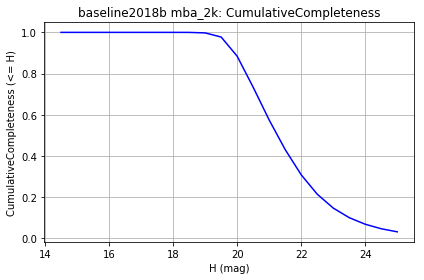

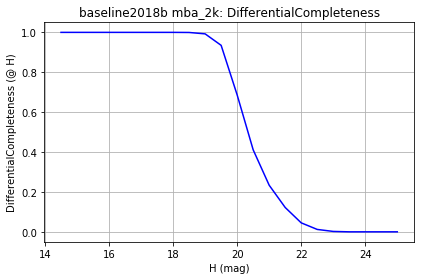

In [18]:
completeness.plot(plotFunc=plots.MetricVsH())
diffcompleteness.plot(plotFunc=plots.MetricVsH())

In [19]:
# Look at the Time bundle - this pulls out the (first) times of discovery of each object. 
bundle.childBundles['Time'].metricValues[0]

masked_array(data = [60113.2838194 60113.2838194 60113.2838194 60113.2838194 60113.2838194
 60113.2838194 60113.2838194 60113.2838194 60113.2838194 60586.22469909999
 61499.21142359999 -- -- -- -- -- -- -- -- -- -- --],
             mask = [False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True],
       fill_value = 0.0)

In [20]:
completeness.summaryValues, diffcompleteness.summaryValues

({'Value At H=23.0': 0.14754248276107712},
 {'Value At H=23.0': 0.002001000500250125})

In [202]:
#Estimate the differential completness for each magnitude in Hrange
cmplH=diffcompleteness.metricValues.data
cmplH2=np.array(cmplH)
cmplH3=cmplH2.flatten()

In [136]:
# #Get estimates for the differential completness for each magnitude in Hrange
# dc=[]
# cmplH=[]
# for Htmp in Hrange:
#     dc.append(mb.makeCompletenessBundle(nchances, summaryName='DifferentialCompleteness', 
#                                              Hmark=Htmp, resultsDb=None))
    
# for i in range(len(Hrange)):    
#     cmplH.append(list(dc[i].summaryValues.values()))
    
# cmplH2=np.array(cmplH)
# cmplH3=cmplH2.flatten()


In [203]:
Hrange

array([ 14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,
        19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,
        23.5,  24. ,  24.5,  25. ])

In [204]:
cmplH3


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  0.99949975,  0.99249625,
        0.93496748,  0.68634317,  0.4112056 ,  0.23361681,  0.12206103,
        0.04502251,  0.012006  ,  0.002001  ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [139]:
# Generate metric bundels that bin observations wrt time
timestep = 1
times = np.arange(s.obs['observationStartMJD'].min(), 
                  s.obs['observationStartMJD'].max() + timestep/2, 
                  timestep)
bundle.childBundles['Time'].summaryValues = None
bundle.childBundles['Time'].summaryMetrics = None

for Htmp in Hrange:
    summaryHTMetric = metrics.MoCompletenessAtTimeMetric(times, Hindex=0.3, Hval=Htmp, cumulative=True, 
                                                         metricName='CumulativeComp%.2f' % Htmp)
    summaryDiffTMetric = metrics.MoCompletenessAtTimeMetric(times, Hindex=0.3, Hval=Htmp, cumulative=False,
                                                           metricName='DifferentialComp%.2f' % Htmp) 
    bundle.childBundles['Time'].setSummaryMetrics([summaryHTMetric, summaryDiffTMetric])
    bundle.childBundles['Time'].computeSummaryStats()

In [140]:
t = bundle.childBundles['Time']
#print(t.summaryValues.keys())


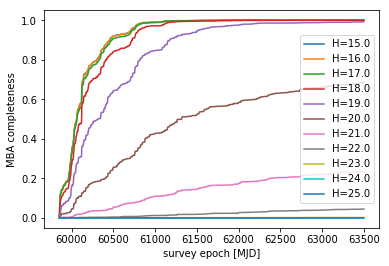

In [141]:
#Plot differential completeness as a function of H and time
j=0
compHt=[]
for k in t.summaryValues.keys():
    if k.startswith('Diff'):
        compHt.append(t.summaryValues[k]['value'])
        if(np.mod(j,2)==1):
            plt.plot(times, compHt[j], label="H=%3.1f" % Hrange[j])
        j=j+1
        
plt.xlabel('survey epoch [MJD]')    
plt.ylabel('MBA completeness') 
plt.legend()
plt.show()

In [142]:
### MAF MAGIC STOPS HERE

In [143]:
#OPEN MPC ORBIT TABLE TO EXTRACT SOME INFORMATION ON THE ALREADY KNOWN POPULATION AND SET POPULATION EXTRAPOLATION POINTS
cwd = '/home/eggls6/sssc2/common/mpcorb/'
mpcfile = os.path.join(cwd, 'MPCORB.TAB')
#obj = pd.read_table(objfile, delim_whitespace=True, usecols=['H','G','M','Peri.','Node','Incl.','e','n','a'])[['H','a','e','Incl.','Peri.','Node','M']]
colspec=[[0,6],[8,13],[14,19],[20,25],[26,35],[37,46],[48,57],[59,68],[70,79],[80,91],[92,103],[117,122],[123,126],[127,131],[132,136],[137,141]]
mpc = pd.read_fwf(mpcfile,colspecs=colspec) 
mbas=mpc.loc[(mpc['a'] < 4) & (mpc['a']*(1.-mpc['e'])>1.5) & (mpc['H']>9) &(mpc['H']<14.5)]
mbasH=mpc.loc[(mpc['a'] < 4) & (mpc['a']*(1.-mpc['e'])>1.5)]['H']
mbasH2=np.array(mbasH)
mbasH3=mbasH2[~np.isnan(mbasH2)]
hist2=np.histogram(mbasH3,bins=Hrange)


In [144]:
mbas[0:3]

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a,#Obs,Opp,A,c,rms
49,00050,9.24,0.15,K194R,158.45937,200.08054,173.52874,2.83822,0.285986,0.228629,2.648794,2498.0,55.0,1857.0,2018,0.49
65,00066,9.36,0.15,K194R,19.07412,43.98510,7.50388,3.04561,0.172941,0.228983,2.646064,2334.0,58.0,1861.0,2018,0.44
83,00084,9.32,0.15,K194R,107.31056,15.15475,327.51444,9.31535,0.235844,0.271425,2.362490,2026.0,48.0,1865.0,2018,0.51


In [145]:
#grab the actual nubmer of discovered objects at H=Hcompl to fit the dN/dH=beta*10^(alpha*H) powerlaw
findcompl=np.isclose(hist2[1],Hcompl)
whereiscompl=np.where(findcompl)[0][0]
beta_a03=hist2[0][whereiscompl]/10**(0.3*Hcompl)

In [157]:
#dN(H) distribution for alpha=0.3: dN/dH=beta*10^(alpha*H)
hist_a03=[nast_diff(hist2[1],0.3,beta_a03),hist2[1]]
hist_a03

[array([  3.20570000e+04,   4.52817161e+04,   6.39621240e+04,
          9.03489016e+04,   1.27621216e+05,   1.80269759e+05,
          2.54637802e+05,   3.59685456e+05,   5.08069211e+05,
          7.17666835e+05,   1.01373135e+06,   1.43193359e+06,
          2.02265996e+06,   2.85708313e+06,   4.03573719e+06,
          5.70063030e+06,   8.05235433e+06,   1.13742528e+07,
          1.60665591e+07,   2.26946180e+07,   3.20570000e+07,
          4.52817161e+07]),
 array([ 14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,
         19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,
         23.5,  24. ,  24.5,  25. ])]

In [175]:
#dN(H) distribution for alpha=0.5
beta_a05=hist2[0][whereiscompl]/10**(0.5*Hcompl)
hist_a05=[nast_diff(hist2[1],0.5,beta_a05),hist2[1]]


22

In [165]:
#calculate index for H where H=Hcomplete
idx=np.where(hist2[1]>Hcompl)[0]

In [186]:
#this is dN/dH for all H values in Hrange for alpha=0.3
dNdH3=nast_diff(Hrange,0.3,beta_a03)

#now we have to find the fraction of the population for each H already known to the MPC
n_a03=np.ones(len(hist2[0]))
n_a03[idx-1]=np.minimum(hist2[0][idx-1]/hist_a03[0][idx-1],1.)
known_a03=1.-n_a03
#known_a03

In [187]:
#this is dN/dH for all H values in Hrange for alpha=0.5
dNdH5=nast_diff(Hrange,0.5,beta_a05)

#now we have to find the fraction of the population for each H already known to the MPC
n_a05=np.ones(len(hist2[0]))
n_a05[idx-1]=hist2[0][idx-1]/hist_a05[0][idx-1]
known_a05=1.-n_a05
#known_a05

In [205]:
#the number of objects discovered by LSST assuming alpha=0.3 for Hrange
disc_H_a03=(cmplH3*dNdH3)[:-1]*known_a03


In [211]:
#the number of objects discovered by LSST assuming alpha=0.5 for Hrange
disc_H_a05=(cmplH3*dNdH5)[:-1]*known_a05

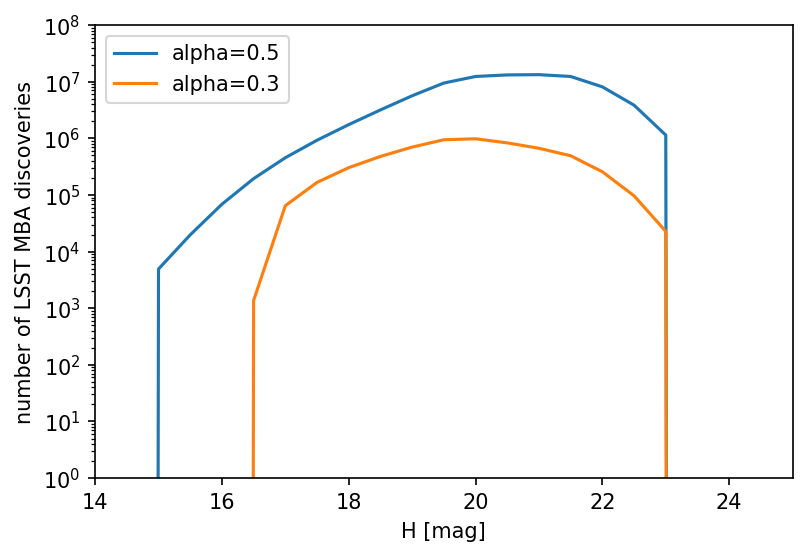

In [212]:
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
plt.plot(Hrange[:-1],disc_H_a05,label="alpha=0.5")
plt.plot(Hrange[:-1],disc_H_a03,label="alpha=0.3")

plt.yscale('log')
plt.ylabel('number of LSST MBA discoveries')
plt.xlabel('H [mag]')
plt.ylim(1,1e8)
plt.legend()
plt.show()

In [213]:
#number of MBAs likely to be discovered by LSST for different H-frequency populations (alpha=0.3,0.5)
ndisc=[int(np.sum(disc_H_a03)*hStep),int(np.sum(disc_H_a05)*hStep)]

print(("alpha=0.3, total=%e") % ndisc[0])
print(("alpha=0.5, total=%e") % ndisc[1])

alpha=0.3, total=3.004141e+06
alpha=0.5, total=4.302974e+07


In [220]:
#MBA discoveries as function of time
dst3=np.zeros(shape=(len(Hrange),len(times)-1))
dst5=np.zeros(shape=(len(Hrange),len(times)-1))
compHt2=np.array(compHt)
dt=timestep
#take the time derivative of the completeness function and scale it to the population corrected by the fraction of already known objects
for j in range(len(Hrange)-1):
     for i in range(1,len(times)-1):
             dst3[j,i]=0.5*(compHt2[j,i+1]-compHt2[j,i-1])*dNdH3[j]*known_a03[j]*dt
             dst5[j,i]=0.5*(compHt2[j,i+1]-compHt2[j,i-1])*dNdH5[j]*known_a05[j]*dt
             #print(dst[j,i])
         

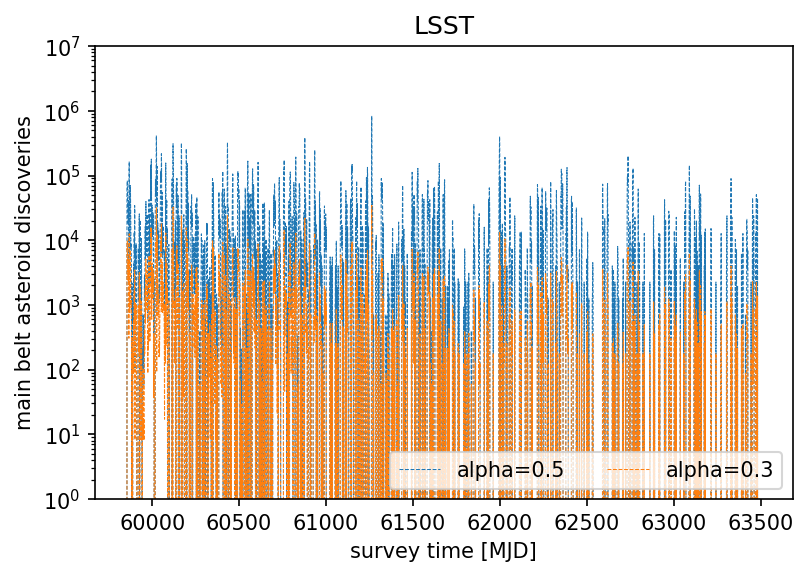

In [221]:
plt.figure(num=None, figsize=(6, 4), dpi=150, facecolor='w', edgecolor='k')
plt.plot(times[1:], np.sum(dst5,0)*hStep,'--',markersize=0.5,linewidth=0.50, label="alpha=0.5")
plt.plot(times[1:], np.sum(dst3,0)*hStep,'--',markersize=0.5,linewidth=0.50, label="alpha=0.3")
plt.yscale("log")
plt.legend(loc='lower right',ncol=3)    
plt.xlabel("survey time [MJD]")
plt.ylabel("main belt asteroid discoveries")
plt.title("LSST")
plt.ylim(1,1e7)
plt.show()


In [222]:
#sum obs histogram over all times (#of discoveries per magnitude)
label1="alpha=0.3, total="+str(ndisc[0])
label2="alpha=0.5, total="+str(ndisc[1])
#Integrate over dH and dt
obssum3=np.sum(dst3,0)*hStep*timestep
obssum5=np.sum(dst5,0)*hStep*timestep

obssum3[0]=0
obssum5[0]=0

tcenter=(times[:-1] + times[1:]) / 2

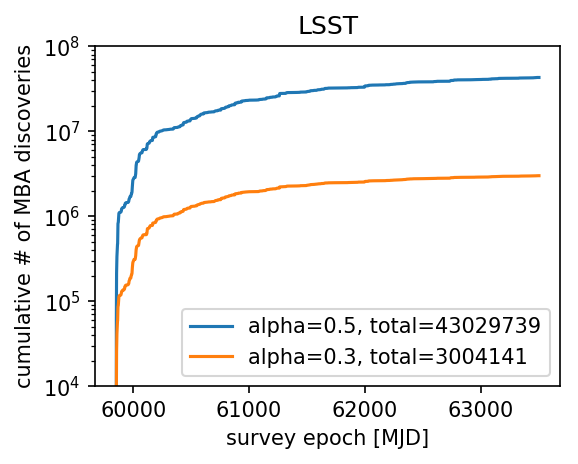

In [223]:
plt.figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
plt.plot(tcenter[:], np.cumsum(obssum5))
plt.plot(tcenter[:],np.cumsum(obssum3))
plt.yscale('log')
plt.ylabel('cumulative # of MBA discoveries')
plt.xlabel('survey epoch [MJD]')
plt.title("LSST")
plt.legend((label2,label1),loc='lower right')
#plt.xlim(60000,63500)
plt.ylim(1e4,1e8)
plt.show()

In [224]:
#WE CAN USE THE CUMULATIVE COMPLETENESS NUMBERS TO CHECK THE ABOVE RESULT
cst3=np.zeros(shape=(len(Hrange),len(times)))
cst5=np.zeros(shape=(len(Hrange),len(times)))

#integrate the differential completeness over dN/dH at every timestep
for j in range(len(Hrange)-1):
     for i in range(len(times)):
             cst3[j,i]=compHt2[j,i]*dNdH3[j]*known_a03[j]
             cst5[j,i]=compHt2[j,i]*dNdH5[j]*known_a05[j]

cumt3=np.sum(cst3,0)*hStep
cumt5=np.sum(cst5,0)*hStep


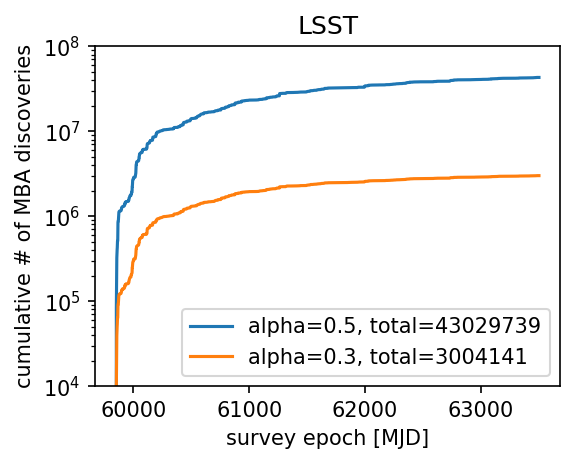

In [225]:
plt.figure(num=None, figsize=(4, 3), dpi=150, facecolor='w', edgecolor='k')
plt.plot(times, cumt5)
plt.plot(times,cumt3)
plt.yscale('log')
plt.ylabel('cumulative # of MBA discoveries')
plt.xlabel('survey epoch [MJD]')
plt.title("LSST")
plt.legend((label2,label1),loc='lower right')
#plt.xlim(60000,63500)
plt.ylim(1e4,1e8)
plt.show()